In [ ]:
# -------------------- IMPORTS --------------------
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report
)
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    Trainer, TrainingArguments
)

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ------------------ Bước 1: Crawl nội dung 1 trang ------------------
def fetch_content(url):
    try:
        resp = requests.get(url, timeout=5, headers={"User-Agent": "Mozilla/5.0"})
        if resp.status_code != 200:
            return None

        warnings.filterwarnings("ignore")
        soup = BeautifulSoup(resp.content, "html.parser")

        # Loại bỏ các tag không cần thiết
        for tag in soup(["script", "style", "noscript", "footer", "nav", "form", "button", "iframe"]):
            tag.extract()

        text = " ".join(soup.get_text().split())

        # Bỏ qua text quá ngắn hoặc lỗi
        if len(text) < 30 or any(err in text.lower() for err in ["error", "not found", "denied"]):
            return None

        return text[:5000]  # Giới hạn text
    except Exception as e:
        with open("error_urls.txt", "a", encoding="utf-8") as f:
            f.write(f"{url} | {str(e)}\n")
        return None

In [ ]:
# ------------------ Bước 2: Keyword gộp URL + text ------------------
keywords_dict = {
    "chính trị": ["quochoi","gov","chinhphu","nghiquyet","election","baocu","dang","party","canbo","politics",
                  "quốc hội","chính phủ","nghị quyết","bầu cử","dân chủ","vote","ứng cử","cơ quan nhà nước","chính sách", "chính trị"],
    "cờ bạc": ["casino","bet","xoso","nhacai","slot","poker","baccarat","jackpot","danhbac","wager",
               "cá cược","xổ số","nhà cái","đánh bạc","quay thưởng","vòng quay","trò chơi","đặt cược",
               "giải đấu","bonus", "uy tín", "game", "bài"],
    "18+": ["phim18","jav","sex","nguoilon","erotic","porn","18plus","adult","hentai","sexvideo",
            "phim người lớn","xxx","khiêu dâm","video sex","người lớn","nude","quan hệ","sexmovie","adultfilm","pornstar"]
}

In [ ]:
# ------------------ Bước 3: Gán label ------------------
def assign_label(url, text, keywords_dict):
    url_lower = url.lower()
    text_lower = text.lower()

    match_count = {}
    for topic, kws in keywords_dict.items():
        match_count[topic] = sum(1 for kw in kws if kw.lower() in url_lower or kw.lower() in text_lower)

    max_count = max(match_count.values())
    if max_count == 0:
        return "nội dung khác"

    candidates = [topic for topic, count in match_count.items() if count == max_count]
    return candidates[0]

In [ ]:
# ------------------ Bước 4: Crawl đa luồng + gán label ------------------
def crawl_and_label(urls_with_labels, max_workers=50):
    results = []

    def worker(item):
        text = fetch_content(item["checked_url"])
        if text:
            label = assign_label(item["checked_url"], text, keywords_dict)
            # Tìm các keyword xuất hiện
            keywords_found = [kw for kw in sum(keywords_dict.values(), []) if kw.lower() in text.lower() or kw.lower() in item["checked_url"].lower()]
            return {
                "url": item["checked_url"],
                "label": label,
                "text": text,
                "keywords_found": list(set(keywords_found))  # unique
            }
        return None

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(worker, item) for item in urls_with_labels]
        for future in futures:
            res = future.result()
            if res:
                results.append(res)

    return results

In [ ]:
# ------------------ Bước 5: Crawl theo batch ------------------
def crawl_all(urls_with_labels, batch_size=5000, max_workers=200):
    all_results = []
    for i in range(0, len(urls_with_labels), batch_size):
        batch = urls_with_labels[i:i+batch_size]
        print(f"Crawl batch {i//batch_size + 1}: {len(batch)} URLs")
        batch_results = crawl_and_label(batch, max_workers=max_workers)
        all_results.extend(batch_results)
    return all_results

In [ ]:
# ------------------ Bước 6: Lưu JSON ------------------
def save_to_json(data, filename="dataset.json"):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [ ]:
# ------------------ Run pipeline ------------------
if __name__ == "__main__":
    csv_path = "../data/raw/raw_data.csv"   
    df = pd.read_csv(csv_path)
    urls_with_labels = [{"checked_url": str(url).strip()} for url in df["checked_url"]]

    dataset = crawl_all(urls_with_labels, batch_size=5000, max_workers=200)

    with open("dataset.json", "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=2)

    print(f"Crawl xong, lưu {len(dataset)} mẫu vào dataset.json")


In [ ]:
# -------------------- LOAD DATA --------------------
with open("dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

texts, labels, urls = [], [], []
for item in data:
    text_part = item.get("text", "")
    kw_part = " ".join(item.get("keywords_found", [])) if isinstance(item.get("keywords_found"), list) else str(item.get("keywords_found"))
    combined_text = f"{item['url']} {text_part} {kw_part}"
    texts.append(combined_text)
    labels.append(item["label"])
    urls.append(item["url"])

# Label mapping
label2id = {"chính trị": 0, "cờ bạc": 1, "18+": 2, "nội dung khác": 3}
id2label = {v: k for k, v in label2id.items()}
y = [label2id[lbl] for lbl in labels]

C:\Users\HP\AppData\Local\Temp\ipykernel_16464\2851963103.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


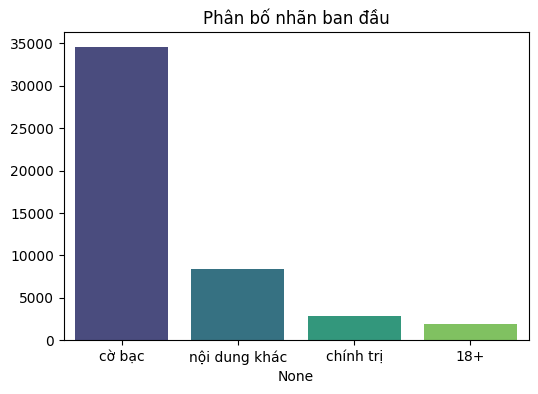

In [10]:
# ==================== PHÂN BỐ BAN ĐẦU ====================
label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Phân bố nhãn ban đầu")
plt.show()

In [ ]:
# ==================== STRATIFIED SPLIT 60/20/20 ====================
# -------------------- DATA SPLIT --------------------
train_val_texts, test_texts, train_val_labels, test_labels, train_val_urls, test_urls = train_test_split(
    texts, y, urls, test_size=0.2, random_state=42, stratify=y
)
train_texts, val_texts, train_labels, val_labels, train_urls, val_urls = train_test_split(
    train_val_texts, train_val_labels, train_val_urls,
    test_size=0.25, random_state=42, stratify=train_val_labels
)

print("Train size:", len(train_texts))
print("Val size:", len(val_texts))
print("Test size:", len(test_texts))

Train size: 28620
Val size: 9540
Test size: 9541


In [ ]:
# -------------------- OVERSAMPLING (BALANCE TRAIN) --------------------
train_df = pd.DataFrame({"text": train_texts, "label": train_labels, "url": train_urls})
train_counts = train_df["label"].value_counts()
max_count = train_counts.max()

balanced_dfs = []
for lbl in train_counts.index:
    df_class = train_df[train_df["label"] == lbl]
    df_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
    balanced_dfs.append(df_resampled)

train_df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
train_texts, train_labels, train_urls = (
    train_df_balanced["text"].tolist(),
    train_df_balanced["label"].tolist(),
    train_df_balanced["url"].tolist()
)

In [13]:
# ==================== TOKENIZATION ====================
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# ==================== TORCH DATASET ====================
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset   = TopicDataset(val_encodings, val_labels)
test_dataset  = TopicDataset(test_encodings, test_labels)

In [15]:
# ==================== CLASS WEIGHTS ====================
orig_counts = Counter(train_labels)
weights = [1.0 / orig_counts.get(i,1) for i in range(len(label2id))]
class_weights = torch.tensor(weights, dtype=torch.float)

In [16]:
# ==================== MODEL ====================
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [18]:
# ==================== METRICS ====================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
# ==================== TRAINING ARGS ====================
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",      # đánh giá theo epoch
    save_strategy="epoch",            # lưu model theo epoch
    logging_dir="./logs",
    logging_steps=200,                # giảm tần suất log
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",                 # tắt wandb/tensorboard nếu không cần
    disable_tqdm=False                 # bật thanh tiến trình % cho HF Trainer
)

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# ==================== TRAIN ====================
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

  1%|▏         | 200/15567 [13:04<16:42:21,  3.91s/it]

{'loss': 0.5492, 'grad_norm': 4.874066352844238, 'learning_rate': 4.935761546861952e-05, 'epoch': 0.04}


  3%|▎         | 400/15567 [26:09<16:41:22,  3.96s/it]

{'loss': 0.2804, 'grad_norm': 1.858486533164978, 'learning_rate': 4.871523093723903e-05, 'epoch': 0.08}


  4%|▍         | 600/15567 [39:15<16:17:15,  3.92s/it]

{'loss': 0.2167, 'grad_norm': 3.6025896072387695, 'learning_rate': 4.807284640585855e-05, 'epoch': 0.12}


  5%|▌         | 800/15567 [52:23<16:14:22,  3.96s/it]

{'loss': 0.1959, 'grad_norm': 1.936692476272583, 'learning_rate': 4.743046187447807e-05, 'epoch': 0.15}


  6%|▋         | 1000/15567 [4:49:05<15:49:06,  3.91s/it]    

{'loss': 0.1681, 'grad_norm': 6.990492820739746, 'learning_rate': 4.678807734309758e-05, 'epoch': 0.19}


  8%|▊         | 1200/15567 [5:02:07<15:35:37,  3.91s/it]

{'loss': 0.1404, 'grad_norm': 0.03996455296874046, 'learning_rate': 4.6145692811717093e-05, 'epoch': 0.23}


  9%|▉         | 1400/15567 [5:15:09<15:22:57,  3.91s/it]

{'loss': 0.1427, 'grad_norm': 7.159667491912842, 'learning_rate': 4.550330828033661e-05, 'epoch': 0.27}


 10%|█         | 1600/15567 [5:28:10<15:09:14,  3.91s/it]

{'loss': 0.137, 'grad_norm': 1.1553181409835815, 'learning_rate': 4.486092374895613e-05, 'epoch': 0.31}


 12%|█▏        | 1800/15567 [5:41:11<14:55:33,  3.90s/it]

{'loss': 0.1161, 'grad_norm': 0.14754875004291534, 'learning_rate': 4.421853921757564e-05, 'epoch': 0.35}


 13%|█▎        | 2000/15567 [5:54:14<14:43:41,  3.91s/it]

{'loss': 0.1148, 'grad_norm': 0.04419601336121559, 'learning_rate': 4.357615468619516e-05, 'epoch': 0.39}


 14%|█▍        | 2200/15567 [6:07:15<14:30:42,  3.91s/it]

{'loss': 0.0852, 'grad_norm': 0.01596526987850666, 'learning_rate': 4.2933770154814675e-05, 'epoch': 0.42}


 15%|█▌        | 2400/15567 [6:20:16<14:18:13,  3.91s/it]

{'loss': 0.1094, 'grad_norm': 0.02829599753022194, 'learning_rate': 4.2291385623434185e-05, 'epoch': 0.46}


 17%|█▋        | 2600/15567 [6:33:17<14:04:30,  3.91s/it]

{'loss': 0.0917, 'grad_norm': 0.19520169496536255, 'learning_rate': 4.164900109205371e-05, 'epoch': 0.5}


 18%|█▊        | 2800/15567 [6:46:18<13:51:12,  3.91s/it]

{'loss': 0.0592, 'grad_norm': 0.12253499031066895, 'learning_rate': 4.1006616560673224e-05, 'epoch': 0.54}


 19%|█▉        | 3000/15567 [6:59:20<13:37:45,  3.90s/it]

{'loss': 0.0763, 'grad_norm': 15.701929092407227, 'learning_rate': 4.0364232029292733e-05, 'epoch': 0.58}


 21%|██        | 3200/15567 [7:12:21<13:25:06,  3.91s/it]

{'loss': 0.0628, 'grad_norm': 6.21629524230957, 'learning_rate': 3.972184749791225e-05, 'epoch': 0.62}


 22%|██▏       | 3400/15567 [7:25:23<13:12:51,  3.91s/it]

{'loss': 0.0678, 'grad_norm': 0.19512143731117249, 'learning_rate': 3.9079462966531766e-05, 'epoch': 0.66}


 23%|██▎       | 3600/15567 [7:38:25<12:59:06,  3.91s/it]

{'loss': 0.0612, 'grad_norm': 0.009436375461518764, 'learning_rate': 3.843707843515129e-05, 'epoch': 0.69}


 24%|██▍       | 3800/15567 [7:51:27<12:46:17,  3.91s/it]

{'loss': 0.0503, 'grad_norm': 0.037120696157217026, 'learning_rate': 3.77946939037708e-05, 'epoch': 0.73}


 26%|██▌       | 4000/15567 [8:04:29<12:33:54,  3.91s/it]

{'loss': 0.0323, 'grad_norm': 0.20799849927425385, 'learning_rate': 3.7152309372390315e-05, 'epoch': 0.77}


 27%|██▋       | 4200/15567 [8:17:31<12:20:35,  3.91s/it]

{'loss': 0.0521, 'grad_norm': 0.19547638297080994, 'learning_rate': 3.650992484100983e-05, 'epoch': 0.81}


 28%|██▊       | 4400/15567 [8:30:33<12:07:46,  3.91s/it]

{'loss': 0.0471, 'grad_norm': 0.11709863692522049, 'learning_rate': 3.586754030962934e-05, 'epoch': 0.85}


 30%|██▉       | 4600/15567 [8:43:35<11:54:19,  3.91s/it]

{'loss': 0.0475, 'grad_norm': 6.175011157989502, 'learning_rate': 3.5225155778248864e-05, 'epoch': 0.89}


 31%|███       | 4800/15567 [8:56:37<11:42:11,  3.91s/it]

{'loss': 0.0411, 'grad_norm': 0.01202724315226078, 'learning_rate': 3.458277124686838e-05, 'epoch': 0.93}


 32%|███▏      | 5000/15567 [9:09:39<11:27:18,  3.90s/it]

{'loss': 0.0323, 'grad_norm': 0.046002019196748734, 'learning_rate': 3.394038671548789e-05, 'epoch': 0.96}


                                                         
 33%|███▎      | 5189/15567 [9:25:06<11:26:43,  3.97s/it]

{'eval_loss': 0.16614370048046112, 'eval_accuracy': 0.969287211740042, 'eval_f1': 0.9696279209633556, 'eval_runtime': 188.1425, 'eval_samples_per_second': 50.706, 'eval_steps_per_second': 3.173, 'epoch': 1.0}


 33%|███▎      | 5200/15567 [9:25:50<15:51:59,  5.51s/it] 

{'loss': 0.0327, 'grad_norm': 0.047636207193136215, 'learning_rate': 3.3298002184107406e-05, 'epoch': 1.0}


 35%|███▍      | 5400/15567 [9:38:50<11:02:04,  3.91s/it]

{'loss': 0.0143, 'grad_norm': 0.0030170436948537827, 'learning_rate': 3.265561765272692e-05, 'epoch': 1.04}


 36%|███▌      | 5600/15567 [9:51:51<10:47:59,  3.90s/it]

{'loss': 0.0241, 'grad_norm': 0.00274845352396369, 'learning_rate': 3.201323312134644e-05, 'epoch': 1.08}


 37%|███▋      | 5800/15567 [10:04:51<10:35:20,  3.90s/it]

{'loss': 0.0305, 'grad_norm': 0.008131353184580803, 'learning_rate': 3.1370848589965955e-05, 'epoch': 1.12}


 39%|███▊      | 6000/15567 [10:17:51<10:22:30,  3.90s/it]

{'loss': 0.0243, 'grad_norm': 0.0030363069381564856, 'learning_rate': 3.072846405858547e-05, 'epoch': 1.16}


 40%|███▉      | 6200/15567 [10:30:52<10:09:14,  3.90s/it]

{'loss': 0.037, 'grad_norm': 14.076892852783203, 'learning_rate': 3.0086079527204984e-05, 'epoch': 1.19}


 41%|████      | 6400/15567 [10:43:52<9:56:10,  3.90s/it] 

{'loss': 0.0205, 'grad_norm': 0.006591532379388809, 'learning_rate': 2.94436949958245e-05, 'epoch': 1.23}


 42%|████▏     | 6600/15567 [10:56:53<9:43:17,  3.90s/it]

{'loss': 0.019, 'grad_norm': 0.003238988807424903, 'learning_rate': 2.880131046444402e-05, 'epoch': 1.27}


 44%|████▎     | 6800/15567 [11:09:54<9:30:45,  3.91s/it]

{'loss': 0.0191, 'grad_norm': 0.14848165214061737, 'learning_rate': 2.8158925933063533e-05, 'epoch': 1.31}


 45%|████▍     | 7000/15567 [11:22:56<9:17:58,  3.91s/it]

{'loss': 0.0243, 'grad_norm': 0.009582034312188625, 'learning_rate': 2.751654140168305e-05, 'epoch': 1.35}


 46%|████▋     | 7200/15567 [11:35:57<9:04:15,  3.90s/it]

{'loss': 0.0278, 'grad_norm': 0.014423487707972527, 'learning_rate': 2.6874156870302562e-05, 'epoch': 1.39}


 48%|████▊     | 7400/15567 [11:48:57<8:52:27,  3.91s/it]

{'loss': 0.0193, 'grad_norm': 0.005722053814679384, 'learning_rate': 2.623177233892208e-05, 'epoch': 1.43}


 49%|████▉     | 7600/15567 [12:01:58<8:37:05,  3.89s/it]

{'loss': 0.0207, 'grad_norm': 0.015275383368134499, 'learning_rate': 2.55893878075416e-05, 'epoch': 1.46}


 50%|█████     | 7800/15567 [12:14:59<8:25:48,  3.91s/it]

{'loss': 0.0212, 'grad_norm': 0.001123145455494523, 'learning_rate': 2.494700327616111e-05, 'epoch': 1.5}


 51%|█████▏    | 8000/15567 [12:28:00<8:11:56,  3.90s/it]

{'loss': 0.012, 'grad_norm': 0.0030655551236122847, 'learning_rate': 2.4304618744780628e-05, 'epoch': 1.54}


 53%|█████▎    | 8200/15567 [12:41:01<8:00:11,  3.91s/it]

{'loss': 0.0151, 'grad_norm': 0.004483277443796396, 'learning_rate': 2.366223421340014e-05, 'epoch': 1.58}


 54%|█████▍    | 8400/15567 [12:54:03<7:46:21,  3.90s/it]

{'loss': 0.0179, 'grad_norm': 0.0024636827874928713, 'learning_rate': 2.301984968201966e-05, 'epoch': 1.62}


 55%|█████▌    | 8600/15567 [13:07:03<7:33:10,  3.90s/it]

{'loss': 0.0145, 'grad_norm': 8.162717819213867, 'learning_rate': 2.2377465150639173e-05, 'epoch': 1.66}


 57%|█████▋    | 8800/15567 [13:20:05<7:21:10,  3.91s/it]

{'loss': 0.0149, 'grad_norm': 0.012300118803977966, 'learning_rate': 2.173508061925869e-05, 'epoch': 1.7}


 58%|█████▊    | 9000/15567 [13:33:08<7:08:33,  3.92s/it]

{'loss': 0.0099, 'grad_norm': 0.0013507481198757887, 'learning_rate': 2.1092696087878206e-05, 'epoch': 1.73}


 59%|█████▉    | 9200/15567 [13:46:10<6:54:28,  3.91s/it]

{'loss': 0.0105, 'grad_norm': 0.0038151119370013475, 'learning_rate': 2.045031155649772e-05, 'epoch': 1.77}


 60%|██████    | 9400/15567 [13:59:11<6:41:38,  3.91s/it]

{'loss': 0.0172, 'grad_norm': 0.0009888035710901022, 'learning_rate': 1.980792702511724e-05, 'epoch': 1.81}


 62%|██████▏   | 9600/15567 [14:12:15<6:29:07,  3.91s/it]

{'loss': 0.0201, 'grad_norm': 0.008657312020659447, 'learning_rate': 1.916554249373675e-05, 'epoch': 1.85}


 63%|██████▎   | 9800/15567 [14:25:17<6:16:21,  3.92s/it]

{'loss': 0.0176, 'grad_norm': 6.700392723083496, 'learning_rate': 1.8523157962356268e-05, 'epoch': 1.89}


 64%|██████▍   | 10000/15567 [14:38:20<6:02:31,  3.91s/it]

{'loss': 0.0074, 'grad_norm': 0.0008309791446663439, 'learning_rate': 1.7880773430975784e-05, 'epoch': 1.93}


 66%|██████▌   | 10200/15567 [14:51:21<5:49:32,  3.91s/it]

{'loss': 0.0147, 'grad_norm': 0.00259383418597281, 'learning_rate': 1.7238388899595297e-05, 'epoch': 1.97}


                                                             
 67%|██████▋   | 10378/15567 [15:40:36<5:53:25,  4.09s/it]

{'eval_loss': 0.19376078248023987, 'eval_accuracy': 0.9742138364779874, 'eval_f1': 0.9741270920297295, 'eval_runtime': 188.5705, 'eval_samples_per_second': 50.591, 'eval_steps_per_second': 3.166, 'epoch': 2.0}


 67%|██████▋   | 10400/15567 [15:42:04<5:40:27,  3.95s/it] 

{'loss': 0.0041, 'grad_norm': 0.003825016086921096, 'learning_rate': 1.6596004368214817e-05, 'epoch': 2.0}


 68%|██████▊   | 10600/15567 [15:55:07<5:25:13,  3.93s/it]

{'loss': 0.011, 'grad_norm': 4.184336185455322, 'learning_rate': 1.595361983683433e-05, 'epoch': 2.04}


 69%|██████▉   | 10800/15567 [16:08:11<5:10:14,  3.90s/it]

{'loss': 0.0072, 'grad_norm': 0.004691294860094786, 'learning_rate': 1.5311235305453846e-05, 'epoch': 2.08}


 71%|███████   | 11000/15567 [16:21:15<4:58:25,  3.92s/it]

{'loss': 0.0103, 'grad_norm': 0.0494065061211586, 'learning_rate': 1.4668850774073362e-05, 'epoch': 2.12}


 72%|███████▏  | 11200/15567 [16:34:19<4:45:37,  3.92s/it]

{'loss': 0.011, 'grad_norm': 0.002037051133811474, 'learning_rate': 1.4026466242692877e-05, 'epoch': 2.16}


 73%|███████▎  | 11400/15567 [16:47:22<4:31:25,  3.91s/it]

{'loss': 0.0095, 'grad_norm': 0.000855032994877547, 'learning_rate': 1.3384081711312393e-05, 'epoch': 2.2}


 75%|███████▍  | 11600/15567 [17:00:25<4:18:04,  3.90s/it]

{'loss': 0.0063, 'grad_norm': 0.0005359593196772039, 'learning_rate': 1.2741697179931908e-05, 'epoch': 2.24}


 76%|███████▌  | 11800/15567 [17:13:30<4:05:45,  3.91s/it]

{'loss': 0.009, 'grad_norm': 2.0561811923980713, 'learning_rate': 1.2099312648551424e-05, 'epoch': 2.27}


 77%|███████▋  | 12000/15567 [17:26:36<3:54:20,  3.94s/it]

{'loss': 0.0061, 'grad_norm': 0.0011319180484861135, 'learning_rate': 1.145692811717094e-05, 'epoch': 2.31}


 78%|███████▊  | 12200/15567 [17:39:39<3:39:22,  3.91s/it]

{'loss': 0.0015, 'grad_norm': 0.0003914272238034755, 'learning_rate': 1.0814543585790455e-05, 'epoch': 2.35}


 80%|███████▉  | 12400/15567 [17:52:41<3:26:55,  3.92s/it]

{'loss': 0.0055, 'grad_norm': 0.001310285646468401, 'learning_rate': 1.017215905440997e-05, 'epoch': 2.39}


 81%|████████  | 12600/15567 [18:05:44<3:13:26,  3.91s/it]

{'loss': 0.0072, 'grad_norm': 0.0009157827589660883, 'learning_rate': 9.529774523029486e-06, 'epoch': 2.43}


 82%|████████▏ | 12800/15567 [18:18:47<3:01:01,  3.93s/it]

{'loss': 0.0016, 'grad_norm': 0.0005280992481857538, 'learning_rate': 8.887389991649002e-06, 'epoch': 2.47}


 84%|████████▎ | 13000/15567 [18:31:50<2:46:58,  3.90s/it]

{'loss': 0.0034, 'grad_norm': 0.0002960684068966657, 'learning_rate': 8.245005460268517e-06, 'epoch': 2.51}


 85%|████████▍ | 13200/15567 [18:44:51<2:33:53,  3.90s/it]

{'loss': 0.0054, 'grad_norm': 0.0003362491261214018, 'learning_rate': 7.602620928888032e-06, 'epoch': 2.54}


 86%|████████▌ | 13400/15567 [18:57:52<2:21:08,  3.91s/it]

{'loss': 0.0001, 'grad_norm': 0.00024358995142392814, 'learning_rate': 6.9602363975075486e-06, 'epoch': 2.58}


 87%|████████▋ | 13600/15567 [19:10:54<2:07:48,  3.90s/it]

{'loss': 0.0034, 'grad_norm': 0.002798534696921706, 'learning_rate': 6.317851866127064e-06, 'epoch': 2.62}


 89%|████████▊ | 13800/15567 [19:23:54<1:55:01,  3.91s/it]

{'loss': 0.0095, 'grad_norm': 0.10491183400154114, 'learning_rate': 5.6754673347465795e-06, 'epoch': 2.66}


 90%|████████▉ | 14000/15567 [19:36:54<1:41:54,  3.90s/it]

{'loss': 0.0041, 'grad_norm': 0.00044333451660349965, 'learning_rate': 5.033082803366095e-06, 'epoch': 2.7}


 91%|█████████ | 14200/15567 [19:49:55<1:28:57,  3.90s/it]

{'loss': 0.0051, 'grad_norm': 0.0009365726727992296, 'learning_rate': 4.3906982719856104e-06, 'epoch': 2.74}


 93%|█████████▎| 14400/15567 [20:02:55<1:15:51,  3.90s/it]

{'loss': 0.0016, 'grad_norm': 0.0004009017429780215, 'learning_rate': 3.7483137406051263e-06, 'epoch': 2.78}


 94%|█████████▍| 14600/15567 [20:15:55<1:02:53,  3.90s/it]

{'loss': 0.0064, 'grad_norm': 0.0006916774436831474, 'learning_rate': 3.1059292092246418e-06, 'epoch': 2.81}


 95%|█████████▌| 14800/15567 [20:28:55<49:55,  3.91s/it]  

{'loss': 0.0098, 'grad_norm': 0.0007022843929007649, 'learning_rate': 2.4635446778441577e-06, 'epoch': 2.85}


 96%|█████████▋| 15000/15567 [20:41:58<37:12,  3.94s/it]

{'loss': 0.0019, 'grad_norm': 0.0006283968687057495, 'learning_rate': 1.8211601464636733e-06, 'epoch': 2.89}


 98%|█████████▊| 15200/15567 [20:55:02<23:57,  3.92s/it]

{'loss': 0.0027, 'grad_norm': 0.0005905318539589643, 'learning_rate': 1.178775615083189e-06, 'epoch': 2.93}


 99%|█████████▉| 15400/15567 [21:08:06<10:52,  3.91s/it]

{'loss': 0.0025, 'grad_norm': 0.0004227035096846521, 'learning_rate': 5.363910837027045e-07, 'epoch': 2.97}


                                                        
100%|██████████| 15567/15567 [21:22:08<00:00,  3.95s/it]

{'eval_loss': 0.20962920784950256, 'eval_accuracy': 0.9731656184486374, 'eval_f1': 0.9728961389021541, 'eval_runtime': 187.2953, 'eval_samples_per_second': 50.936, 'eval_steps_per_second': 3.187, 'epoch': 3.0}


100%|██████████| 15567/15567 [21:22:09<00:00,  4.94s/it]

{'train_runtime': 76929.7123, 'train_samples_per_second': 3.238, 'train_steps_per_second': 0.202, 'train_loss': 0.04664147071472871, 'epoch': 3.0}


TrainOutput(global_step=15567, training_loss=0.04664147071472871, metrics={'train_runtime': 76929.7123, 'train_samples_per_second': 3.238, 'train_steps_per_second': 0.202, 'total_flos': 3.2995096717492224e+16, 'train_loss': 0.04664147071472871, 'epoch': 3.0})

100%|██████████| 597/597 [03:05<00:00,  3.22it/s]


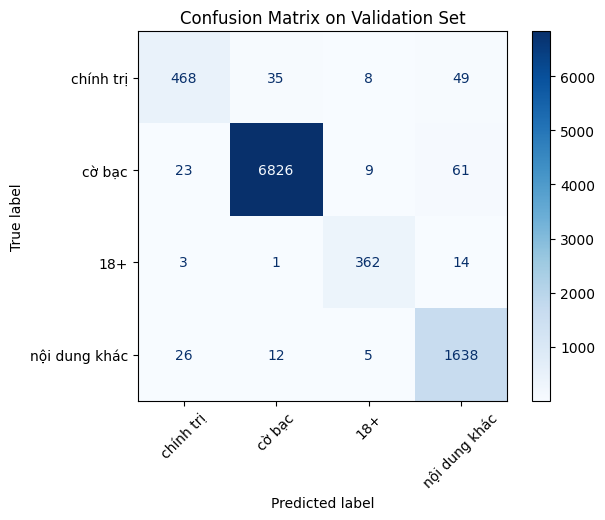


------ Classification Report (Validation) ------
               precision    recall  f1-score   support

    chính trị     0.9000    0.8357    0.8667       560
       cờ bạc     0.9930    0.9866    0.9898      6919
          18+     0.9427    0.9526    0.9476       380
nội dung khác     0.9296    0.9744    0.9515      1681

     accuracy                         0.9742      9540
    macro avg     0.9413    0.9373    0.9389      9540
 weighted avg     0.9744    0.9742    0.9741      9540



100%|██████████| 597/597 [03:05<00:00,  3.22it/s]


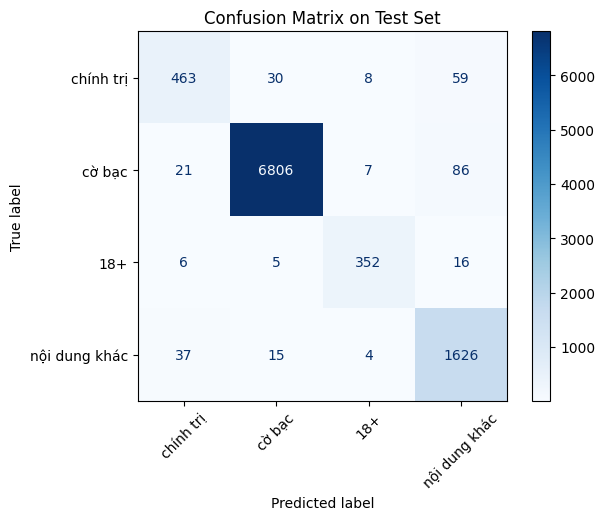


------ Classification Report (Test) ------
               precision    recall  f1-score   support

    chính trị     0.8786    0.8268    0.8519       560
       cờ bạc     0.9927    0.9835    0.9881      6920
          18+     0.9488    0.9288    0.9387       379
nội dung khác     0.9099    0.9667    0.9374      1682

     accuracy                         0.9692      9541
    macro avg     0.9325    0.9264    0.9290      9541
 weighted avg     0.9697    0.9692    0.9692      9541



In [30]:
# -------------------- EVALUATION --------------------
def eval_and_report(dataset, true_labels, set_name="Validation"):
    preds = trainer.predict(dataset)
    y_true = true_labels
    y_pred = np.argmax(preds.predictions, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix on {set_name} Set")
    plt.show()

    # Classification Report
    print(f"\n------ Classification Report ({set_name}) ------")
    print(classification_report(y_true, y_pred, target_names=list(label2id.keys()), digits=4))
    return y_pred

# Validation
y_pred_val = eval_and_report(val_dataset, val_labels, set_name="Validation")
# Test
y_pred_test = eval_and_report(test_dataset, test_labels, set_name="Test")

In [31]:
# -------------------- SAVE TEST PREDICTIONS --------------------
df_test_out = pd.DataFrame({
    "url": test_urls,
    "true_label": [id2label[i] for i in test_labels],
    "predicted_label": [id2label[i] for i in y_pred_test]
})
df_test_out.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to test_predictions.csv")

Test predictions saved to test_predictions.csv


In [32]:
# -------------------- SAVE MODEL --------------------
checkpoint_path = trainer.state.best_model_checkpoint
model = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')